In [474]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import idct

Variable initialization

In [475]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [476]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    DCT[:, i] = temp/norm


Generating the 1-D standard basis

In [477]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

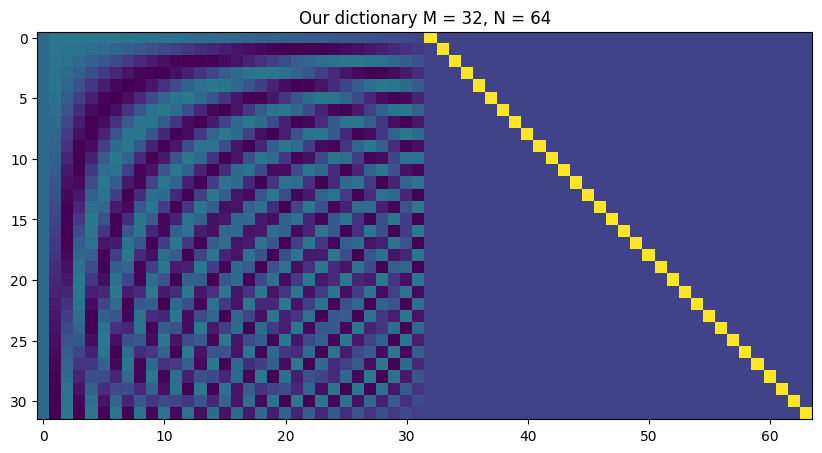

In [478]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [479]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [480]:
x0 = np.zeros(N)
positions = np.random.choice(N, L, replace=False)
x0[positions] = np.random.rand(L)
x0

array([0.        , 0.        , 0.        , 0.        , 0.37787863,
       0.        , 0.66556399, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.58801119, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04313689, 0.        , 0.        ])

Choose spike location

In [481]:
# choose random position from M to N (N = 2M)
spikeLocation = np.random.choice(M) + M # from 32 to 64
print(spikeLocation)
#add spike to x0
x0[spikeLocation] = 4*np.abs(max(x0)) # this is to make the spike at least 4 times bigger than the biggest magnitude on signal
x0

47


array([0.        , 0.        , 0.        , 0.        , 0.37787863,
       0.        , 0.66556399, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.58801119, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.66225596, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04313689, 0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [482]:
# s0 = Dx
s0 = D @ x0 # noise free

# add noise
sigma_noise = sigma_noise * (np.random.normal(size=s0.shape))

# s = s0 + eta
s = s0 + sigma_noise

Plot the sparse signal

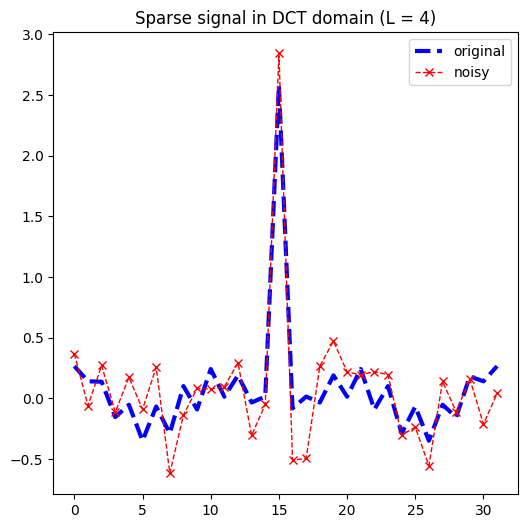

In [483]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [484]:
x_OMP = np.zeros(N)

# residual
r =  s - (D @ x_OMP)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stopping criteria: continue until the sparsity of the representation reaches L

In [485]:
while np.linalg.norm(r) > MINIMUM_NORM_RES and np.count_nonzero(x_OMP) < L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        zj = ((r.T @ dj) / np.linalg.norm(dj))**2
        e[j] = np.linalg.norm(r)**2 - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)
    # this makes sense but it makes the graph soften the spikes because it's not using all the points
    # if jStar not in omega: # because omega is a set
    #     omega.append(jStar) # this also guarantees to obtain a singular matrix

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:,omega]
    l_term = np.linalg.inv(D_omega.T @ D_omega)
    r_term = D_omega.T @ s
    x_omega = l_term @ r_term

    x_OMP[omega] = x_omega

    # update the residual
    r = s - (D @ x_OMP)


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [486]:
s_hat_OMP = (D @ x_OMP)
s_hat_OMP

array([ 0.06917922,  0.02834947,  0.15074083, -0.04899413,  0.07713286,
       -0.27914208, -0.07632265, -0.35360135,  0.06559092, -0.04297518,
        0.39843991,  0.21087756,  0.33700456, -0.03144301, -0.14764729,
        2.84359646, -0.35718965, -0.14764729, -0.03144301,  0.33700456,
        0.21087756,  0.39843991, -0.04297518,  0.06559092, -0.35360135,
       -0.07632265, -0.27914208,  0.07713286, -0.04899413,  0.15074083,
        0.02834947,  0.06917922])

Show the result

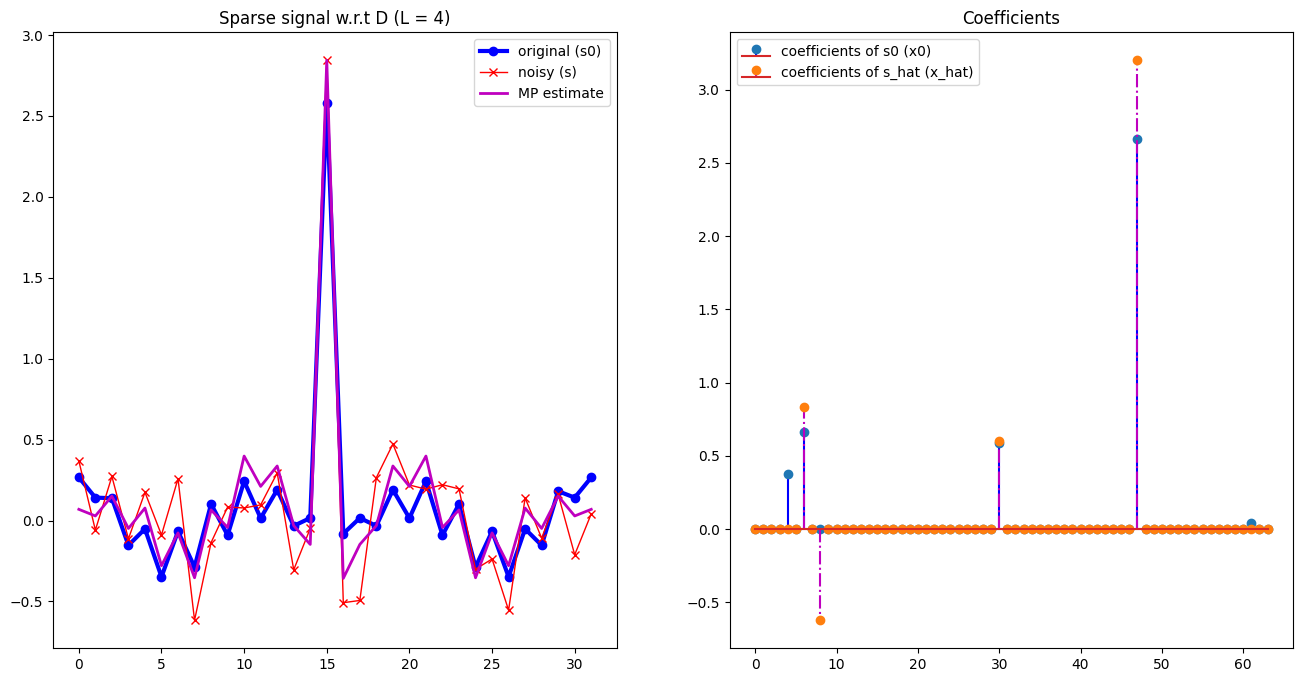

In [487]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [488]:
x_LSOMP = np.zeros(N)

# residual
r = s - (D @ x_LSOMP)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [489]:
while np.linalg.norm(r) > MINIMUM_NORM_RES and np.count_nonzero(x_OMP) < L:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            dj = D[:,j]
            zj = ((r.T @ dj) / np.linalg.norm(dj))**2
            e[j] = np.linalg.norm(r)**2 - zj

        # find the column of D that matches at best r
        jStar = np.argmin(e)
        omega.append(jStar)

        D_omega = D[:,omega]
        l_term = np.linalg.inv(D_omega.T @ D_omega)
        r_term = D_omega.T @ s
        x_omega = l_term @ r_term

        x_OMP[omega] = x_omega

    else:
        # perform the sweep step by solving the LS problem
        e = np.ones(N) * np.inf
        zwu_dict = {}
        for j in range(N):
            if j not in omega: # because omega is a set
                Dw = D[:,omega]
                dj = D[:,j]
                Dw_dj = np.hstack((Dw, dj.reshape((-1,1))))
                l_term = Dw_dj.T @ Dw_dj
                r_term = Dw_dj.T @ s
                zwu = np.linalg.inv(l_term) @ r_term
                zwu_dict[j] = zwu
                e[j] = np.linalg.norm(s - (Dw_dj @ zwu))**2
                # print(j)
            
        jStar = np.argmin(e)
        zwu = zwu_dict[jStar]
        
        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
            
        # update the coefficients
        x_LSOMP[omega] = zwu
        
    # update the residual
    r = s - (D @ x_LSOMP)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [490]:
s_hat_LSOMP = (D @ x_LSOMP)

Show the result

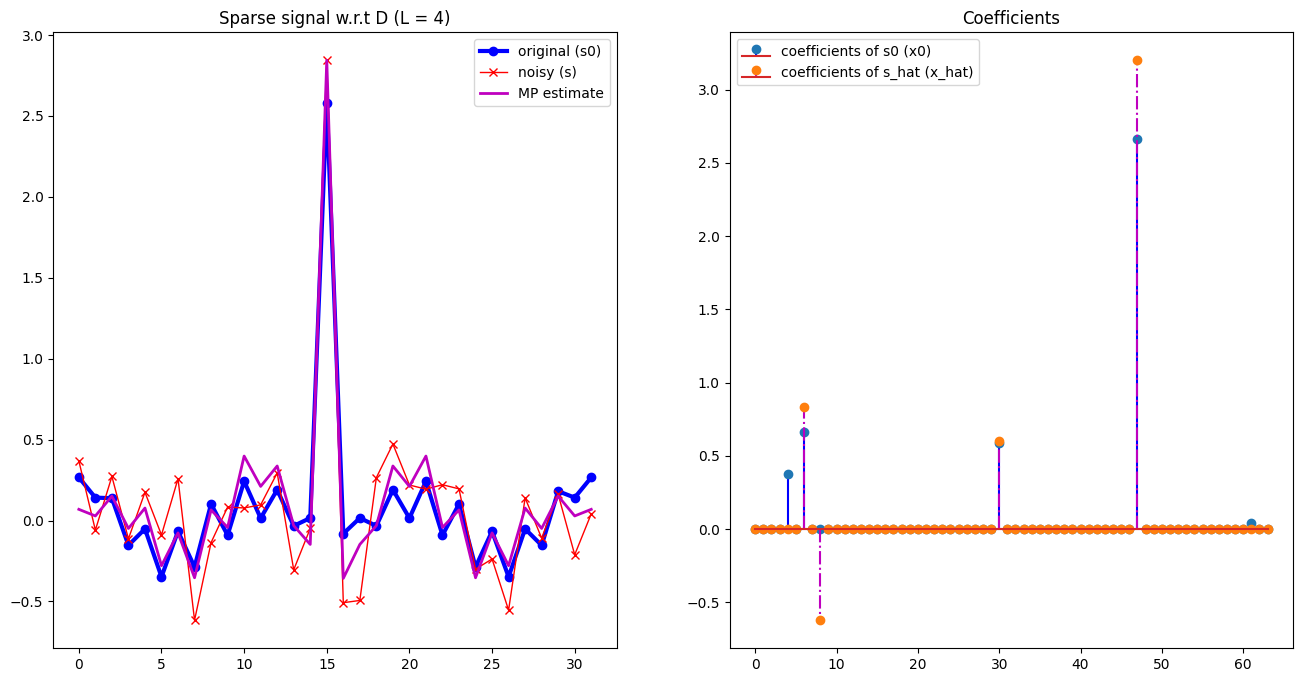

In [491]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])